# Hourly Energy Demand Time Series Forecast

In this notebook we explore the various methods of forecasting in times series. Points covered in this notebook:
* Preprocessing the data
* Applying models and comparing their performance

This notebook is not exhaustive in presenting the methods for forecasting.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
# Any results you write to the current directory are saved as output.

/kaggle/input/energy-consumption-generation-prices-and-weather/energy_dataset.csv
/kaggle/input/energy-consumption-generation-prices-and-weather/weather_features.csv


Using TensorFlow backend.


In [2]:
df = pd.read_csv("../input/energy-consumption-generation-prices-and-weather/energy_dataset.csv")

In [3]:
df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0000,329.0000,0.0000,4844.0000,4821.0000,162.0000,0.0000,0.0000,0.0000,...,196.0000,0.0000,6378.0000,17.0000,nan,6436.0000,26118.0000,25385.0000,50.1000,65.4100
1,2015-01-01 01:00:00+01:00,449.0000,328.0000,0.0000,5196.0000,4755.0000,158.0000,0.0000,0.0000,0.0000,...,195.0000,0.0000,5890.0000,16.0000,nan,5856.0000,24934.0000,24382.0000,48.1000,64.9200
2,2015-01-01 02:00:00+01:00,448.0000,323.0000,0.0000,4857.0000,4581.0000,157.0000,0.0000,0.0000,0.0000,...,196.0000,0.0000,5461.0000,8.0000,nan,5454.0000,23515.0000,22734.0000,47.3300,64.4800
3,2015-01-01 03:00:00+01:00,438.0000,254.0000,0.0000,4314.0000,4131.0000,160.0000,0.0000,0.0000,0.0000,...,191.0000,0.0000,5238.0000,2.0000,nan,5151.0000,22642.0000,21286.0000,42.2700,59.3200
4,2015-01-01 04:00:00+01:00,428.0000,187.0000,0.0000,4130.0000,3840.0000,156.0000,0.0000,0.0000,0.0000,...,189.0000,0.0000,4935.0000,9.0000,nan,4861.0000,21785.0000,20264.0000,38.4100,56.0400


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
time                                           35064 non-null object
generation biomass                             35045 non-null float64
generation fossil brown coal/lignite           35046 non-null float64
generation fossil coal-derived gas             35046 non-null float64
generation fossil gas                          35046 non-null float64
generation fossil hard coal                    35046 non-null float64
generation fossil oil                          35045 non-null float64
generation fossil oil shale                    35046 non-null float64
generation fossil peat                         35046 non-null float64
generation geothermal                          35046 non-null float64
generation hydro pumped storage aggregated     0 non-null float64
generation hydro pumped storage consumption    35045 non-null float64
generation hydro run-of-river and poundage     35045 non

In [5]:
mape = np.mean(np.abs((df['total load actual'] - df['total load forecast']) / df['total load actual'])) * 100
print('MAPE of the forecasted data present in DataFrame:', mape)

MAPE of the forecasted data present in DataFrame: 1.096023073723821


# Preprocessing

Here we extract the single feature we will predict, i.e. `total load actual`. Then we scale the feature using a MinMaxScaler. To prepare the data for the models, use `create_dataset` function which takes the data and creates chunks of it based on the `look_back`. 

The preprocessing works as follows:
Example data: `[1,2,3,4,5]`
After preprocessing (x -> y): 
>`[1,2]` -> `[3]` <br>
>`[2,3]` -> `[4]` <br>
>`[3,4]` -> `[5]` <br>

when `look_back` is set to 2. This preprocessing is only required for LSTM. Rest of the models take input as a series with single feature.

In [6]:
temp = df.copy() 
dataset = temp['total load actual'].dropna().values
dataset = dataset.astype('float32') 
dataset = np.reshape(dataset, (-1, 1)) 

scaler = MinMaxScaler(feature_range=(0, 1)) 
dataset = scaler.fit_transform(dataset) 

# Train and Test splits
train_size = int(len(dataset) * 0.80) 
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 25 
X_train, trainY = create_dataset(train, look_back)
X_test, testY = create_dataset(test, look_back)


X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print("Shapes: \nTraining set: {}, Testing set: {}".format(X_train.shape, X_test.shape))
print("Sample from training set: \n{}".format(X_train[0]))

Shapes: 
Training set: (27996, 1, 25), Testing set: (6980, 1, 25)
Sample from training set: 
[[0.31966567 0.27600765 0.20427442 0.14124662 0.09676152 0.08113521
  0.08570558 0.10168016 0.08936191 0.11299729 0.1832071  0.23966217
  0.26516938 0.2904153  0.2886306  0.23883522 0.22098899 0.2422303
  0.36589193 0.43436062 0.47762692 0.5018717  0.47836685 0.38117003
  0.39300954]]


## LSTM

Long short-term memory is an artificial recurrent neural network architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points, but also entire sequences of data

In [16]:
temp = df
dataset = temp['total load actual'].dropna().values 
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 25
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

[[0.31966571 0.27600766 0.2042744  0.14124663 0.09676156 0.0811352
  0.08570558 0.10168016 0.08936189 0.1129973  0.1832071  0.23966223
  0.26516932 0.29041525 0.28863063 0.23883521 0.22098894 0.24223035
  0.36589188 0.43436058 0.47762688 0.50187168 0.47836685 0.38117002
  0.39300949]]
1 25


In [8]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=200, batch_size=70, validation_data=(X_test, Y_test),verbose=1, shuffle=False)

model.summary()

Train on 27996 samples, validate on 6980 samples
Epoch 1/200
27996/27996 [==============================] - 2s 58us/step - loss: 0.0123 - val_loss: 0.0028
Epoch 2/200
27996/27996 [==============================] - 1s 41us/step - loss: 0.0033 - val_loss: 0.0017
Epoch 3/200
27996/27996 [==============================] - 1s 42us/step - loss: 0.0025 - val_loss: 0.0013
Epoch 4/200
27996/27996 [==============================] - 1s 44us/step - loss: 0.0022 - val_loss: 0.0012
Epoch 5/200
27996/27996 [==============================] - 1s 43us/step - loss: 0.0020 - val_loss: 0.0010
Epoch 6/200
27996/27996 [==============================] - 1s 46us/step - loss: 0.0018 - val_loss: 9.8919e-04
Epoch 7/200
27996/27996 [==============================] - 1s 44us/step - loss: 0.0017 - val_loss: 9.7252e-04
Epoch 8/200
27996/27996 [==============================] - 1s 43us/step - loss: 0.0016 - val_loss: 9.2688e-04
Epoch 9/200
27996/27996 [==============================] - 1s 43us/step - loss: 0.0015 - va

In [23]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 362.61544827274435
Train Root Mean Squared Error: 575.8877047400015
Test Mean Absolute Error: 340.9199271915294
Test Root Mean Squared Error: 541.3221878100229


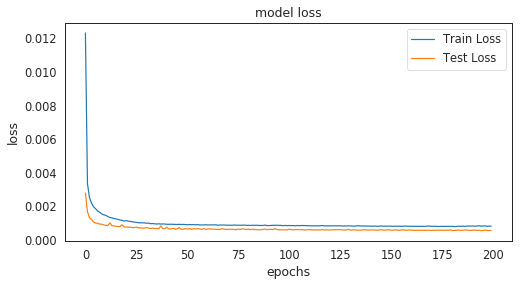

In [24]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

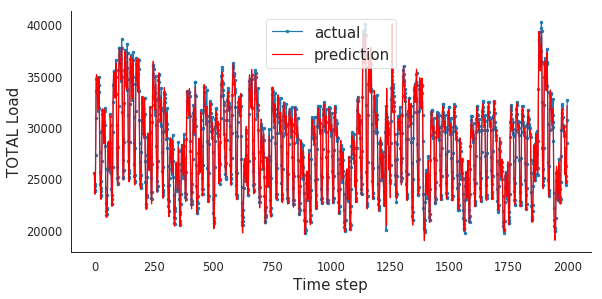

In [27]:
idx = 2000
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:idx], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL Load', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();